### Objective
* Find the percentage of active customers compare to the total number of customers after each month: Customer Segmentations 
* Interprete the retention rate gotten

* Find the percentage of purchases made by each cohort monthly 
* Interprete the result

### Import all the required libraries

In [1]:
#Import the important libraries 
import pandas as pd
import numpy as np
import random
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None  # default='warn'

### Data Loading

In [2]:
#REead the data from the data set, choose you prefered sheet
purchases = pd.read_excel('online_retail_II.xlsx', 'Year_2009_2010')

### Import and prepare the data

In [3]:
purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   CustomerID   417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [4]:
# Change the data format for InvoiceDate to date. This will make the subsequent analysis easier.
purchases['InvoiceDate']=pd.to_datetime(purchases['InvoiceDate'])

In [5]:
# Remove transactions with null customer ID values
purchases = purchases.dropna(axis =0, subset =['CustomerID'])

In [6]:
#know the data range
print('Min:{}; Max:{}'.format(min(purchases.InvoiceDate),
                             max(purchases.InvoiceDate)))

Min:2009-12-01 07:45:00; Max:2010-12-09 20:01:00


In [7]:
# Look-out for duplicate entries and delete them
print('Duplicate entries: {}'.format(purchases.duplicated().sum()))
purchases.drop_duplicates(inplace = True)

Duplicate entries: 6771


In [8]:
# Check the number of customers, products and transactions in the dataset
pd.DataFrame([{'products': len(purchases['StockCode'].value_counts()),    
               'transactions': len(purchases['InvoiceNo'].value_counts()),
               'customers': len(purchases['CustomerID'].value_counts()),  
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,4031,23587,4383


In [9]:
# Group the data by customers and invoice number to get a sense of purchase behaviour
temp = purchases.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket[:20].sort_values('CustomerID')

,CustomerID,InvoiceNo,Number of products
0,12346.0,491725,1
14,12346.0,C525274,1
13,12346.0,C525099,1
12,12346.0,C514024,9
11,12346.0,C495800,1
10,12346.0,513774,19
8,12346.0,495295,1
9,12346.0,499763,5
6,12346.0,493412,1
5,12346.0,493410,1


In [10]:
# Certain invoice numbers have the letter 'C' in them. These might correspond to cancelled orders. Check number of transactions corresponding to cancelled orders
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x: 'C' in str(x))
display(nb_products_per_basket[:5])
n1 = nb_products_per_basket['order_canceled'].sum()
n2 = nb_products_per_basket.shape[0]
print('Number of orders canceled: {}/{} ({:.2f}%) '.format(n1, n2, n1/n2*100))

,CustomerID,InvoiceNo,Number of products,order_canceled
0,12346.0,491725,1,False
1,12346.0,491742,1,False
2,12346.0,491744,1,False
3,12346.0,492718,1,False
4,12346.0,492722,1,False


Number of orders canceled: 4372/23587 (18.54%) 


In [11]:
#View the first five row 
display(purchases.sort_values('CustomerID')[:5])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
253045,513774,20685,DOORMAT RED SPOT,1,2010-06-28 13:53:00,7.49,12346.0,United Kingdom
45228,493410,TEST001,This is a test product.,5,2010-01-04 09:24:00,4.50,12346.0,United Kingdom
253042,513774,48188,DOORMAT WELCOME PUPPIES,1,2010-06-28 13:53:00,7.49,12346.0,United Kingdom
253043,513774,48187,DOORMAT NEW ENGLAND,1,2010-06-28 13:53:00,7.49,12346.0,United Kingdom
253044,513774,22366,DOORMAT AIRMAIL,1,2010-06-28 13:53:00,7.49,12346.0,United Kingdom


In [12]:
# It appears that a cancelled transaction has a corresponding purchase with a positive quantity for the same customerID, description and unit price. Let's check if this is true.
df_check = purchases[purchases['Quantity'] < 0][['CustomerID','Quantity',
                                                   'StockCode','Description','Price']]
for index, col in  df_check.iterrows():
    if purchases[(purchases['CustomerID'] == col[0]) & (purchases['Quantity'] == -col[1]) 
                & (purchases['Description'] == col[2])].shape[0] == 0: 
        print(df_check.loc[index])
        print('NOT TRUE')
        break

CustomerID                      16321.0
Quantity                            -12
StockCode                         22087
Description    PAPER BUNTING WHITE LACE
Price                              2.95
Name: 178, dtype: object
NOT TRUE


In [13]:
# Our hypothesis above is not true since we found an entry for discount. Lets check again but this time discarding the discount entries
df_check = purchases[(purchases['Quantity'] < 0) & (purchases['Description'] != 'Discount')][
                                 ['CustomerID','Quantity','StockCode',
                                  'Description','Price']]

for index, col in  df_check.iterrows():
    if purchases[(purchases['CustomerID'] == col[0]) & (purchases['Quantity'] == -col[1]) 
                & (purchases['Description'] == col[2])].shape[0] == 0: 
        print(index, df_check.loc[index])
        print('NOT TRUE')
        break

178 CustomerID                      16321.0
Quantity                            -12
StockCode                         22087
Description    PAPER BUNTING WHITE LACE
Price                              2.95
Name: 178, dtype: object
NOT TRUE


In [14]:
# It turns out that cancellations do not necessarily correspond to orders that would have been made beforehand. 
#For the cancellations without counterparts, a few of them are probably due to the fact
# that few of these transactions were performed before December 2010 (the start of the entries in the dataset).

In [15]:
# Create a summary of cancelled orders and check for the existence of counterparts
purchases_cleaned = purchases.copy(deep = True)
purchases_cleaned['QuantityCancelled'] = 0

entry_to_remove = []; doubtful_entry = []

for index, col in purchases.iterrows():
    if(col['Quantity'] > 0) or col['Description'] == 'Discount' : continue
    df_test = purchases[(purchases['CustomerID'] == col['CustomerID']) &
                        (purchases['StockCode']  == col['StockCode']) &
                        (purchases['InvoiceDate'] < col['InvoiceDate']) &
                        (purchases['Quantity'] > 0)].copy()
                       
    #_________________________________
    # Cancellation WITHOUT counterpart
    if (df_test.shape[0] == 0): 
        doubtful_entry.append(index)
    #________________________________
    # Cancellation WITH a counterpart
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        purchases_cleaned.loc[index_order, 'QuantityCancelled'] = -col['Quantity']
        entry_to_remove.append(index)        
    #______________________________________________________________
    # Various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            purchases_cleaned.loc[ind, 'QuantityCancelled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break       

print("entry_to_remove: {}".format(len(entry_to_remove)))
print("doubtful_entry: {}".format(len(doubtful_entry)))


entry_to_remove: 8054
doubtful_entry: 1614


In [16]:
# Drop the above entries and also check for other entries to be deleted
purchases_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
purchases_cleaned.drop(doubtful_entry, axis = 0, inplace = True)
remaining_entries = purchases_cleaned[(purchases_cleaned['Quantity'] < 0) & (purchases_cleaned['StockCode'] != 'D')]
print("nb of entries to delete: {}".format(remaining_entries.shape[0]))
remaining_entries[:5]

nb of entries to delete: 56


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,QuantityCancelled
9324,C490133,21314,SMALL GLASS HEART TRINKET POT,-504,2009-12-03 18:36:00,1.85,17949.0,United Kingdom,0
28066,C491728,22139,RETRO SPOT TEA SET CERAMIC 11 PC,-4,2009-12-14 09:18:00,4.95,12471.0,Germany,0
46326,C493689,79000,MOROCCAN TEA GLASS,-18,2010-01-05 12:45:00,0.85,14606.0,United Kingdom,0
47742,C493836,84050,PINK HEART SHAPE EGG FRYING PAN,-24,2010-01-07 13:49:00,1.65,12839.0,United Kingdom,0
69168,C495516,72739C,DARK CHOCOLATE SCENTCANDLE,-13,2010-01-25 14:26:00,1.25,13564.0,United Kingdom,0


In [17]:
# Remove any remaining transactions with negative quantities
purchases_cleaned = purchases_cleaned[(purchases_cleaned['Quantity'] > 0)]
purchases_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400947 entries, 0 to 525460
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   InvoiceNo          400947 non-null  object        
 1   StockCode          400947 non-null  object        
 2   Description        400947 non-null  object        
 3   Quantity           400947 non-null  int64         
 4   InvoiceDate        400947 non-null  datetime64[ns]
 5   Price              400947 non-null  float64       
 6   CustomerID         400947 non-null  float64       
 7   Country            400947 non-null  object        
 8   QuantityCancelled  400947 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 30.6+ MB


In [18]:
# Drop column - 'Quantity cancelled' 
del purchases_cleaned['QuantityCancelled']

In [19]:
# Get the invoice month from the invoice date
def get_month(x): return dt.datetime(x.year, x.month, 1)
purchases_cleaned['InvoiceMonth'] = purchases_cleaned['InvoiceDate'].apply(get_month)

In [20]:
purchases_cleaned.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,InvoiceMonth
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,2009-12-01
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009-12-01
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009-12-01
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,2009-12-01
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,2009-12-01


In [21]:
# Group by Invoice Month to view transactions by month
purchases_cleaned.groupby('InvoiceMonth').count()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
InvoiceMonth,,,,,,,,
2009-12-01,30279,30279,30279,30279,30279,30279,30279,30279
2010-01-01,21461,21461,21461,21461,21461,21461,21461,21461
2010-02-01,23042,23042,23042,23042,23042,23042,23042,23042
2010-03-01,31783,31783,31783,31783,31783,31783,31783,31783
2010-04-01,26834,26834,26834,26834,26834,26834,26834,26834
2010-05-01,28233,28233,28233,28233,28233,28233,28233,28233
2010-06-01,30691,30691,30691,30691,30691,30691,30691,30691
2010-07-01,26644,26644,26644,26644,26644,26644,26644,26644
2010-08-01,26030,26030,26030,26030,26030,26030,26030,26030


In [22]:
# Focus is on 2010 data
purchases2 = purchases_cleaned.loc[purchases_cleaned['InvoiceMonth'] != '2009-12-01']

In [23]:
# Check the number of products, transactions and customers in the 2010 data. Use this data for further analysis. 
pd.DataFrame([{'products': len(purchases2['StockCode'].value_counts()),    
               'transactions': len(purchases2['InvoiceNo'].value_counts()),
               'customers': len(purchases2['CustomerID'].value_counts()),  
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,3890,17703,4201


In [24]:
# Group transactions by month 
purchases2.groupby('InvoiceMonth').count()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
InvoiceMonth,,,,,,,,
2010-01-01,21461,21461,21461,21461,21461,21461,21461,21461
2010-02-01,23042,23042,23042,23042,23042,23042,23042,23042
2010-03-01,31783,31783,31783,31783,31783,31783,31783,31783
2010-04-01,26834,26834,26834,26834,26834,26834,26834,26834
2010-05-01,28233,28233,28233,28233,28233,28233,28233,28233
2010-06-01,30691,30691,30691,30691,30691,30691,30691,30691
2010-07-01,26644,26644,26644,26644,26644,26644,26644,26644
2010-08-01,26030,26030,26030,26030,26030,26030,26030,26030
2010-09-01,34131,34131,34131,34131,34131,34131,34131,34131


In [25]:
#group by the customer id and the Invoice month (Sice this is mothly time cohorts )
grouping = purchases2.groupby('CustomerID')['InvoiceMonth']
# Create a column for Cohort Month. This captures the month of the first transaction for a customer.
purchases2['CohortMonth'] = grouping.transform('min')
purchases2['CohortMonth']=pd.to_datetime(purchases2['CohortMonth'], format = '%Y-%m-%d')

### Get the time offset in Months 
#### Use it as the cohort index 

In [26]:
# Define a function to get the year, month and day from a date
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

In [27]:
# Calculate the cohort index which calculates the number of months since the first transaction
invoice_year, invoice_month, invoice_day = get_date_int(purchases2, 'InvoiceMonth')
cohort_year, cohort_month, cohort_day = get_date_int(purchases2, 'CohortMonth')
years_diff = invoice_year - cohort_year
months_diff = invoice_month - cohort_month
purchases2['CohortIndex'] = years_diff * 12 + months_diff + 1

In [28]:
# Calculate the count of members in each cohort. This will be used for retention analysis.
grouping = purchases2.groupby(['CohortMonth','CohortIndex'])
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index = 'CohortMonth', columns = 'CohortIndex', values = 'CustomerID')

### Get the Retention rate 

In [29]:
# Store the first column as cohort sizes
cohort_sizes = cohort_counts.iloc[:,0]

# Divide all values in the cohort_counts table by cohort_sizes
retention = cohort_counts.divide(cohort_sizes, axis = 0)
retention.index =retention.index.strftime('%Y-%m')
# Review the retention table
retention.round(3)*100


CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,
2010-01,100.0,36.4,47.2,43.8,39.4,42.5,39.4,37.4,39.4,43.9,46.4,23.2
2010-02,100.0,28.1,27.5,33.2,30.7,26.0,24.4,35.2,31.8,35.2,13.7,NaN
2010-03,100.0,22.3,25.0,26.7,23.7,22.3,26.7,34.0,33.3,11.0,NaN,NaN
2010-04,100.0,20.1,20.7,18.7,19.3,22.6,29.3,30.2,9.8,NaN,NaN,NaN
2010-05,100.0,17.5,18.5,17.5,17.5,26.3,23.6,8.4,NaN,NaN,NaN,NaN
2010-06,100.0,16.4,18.7,21.1,24.1,30.1,7.4,NaN,NaN,NaN,NaN,NaN
2010-07,100.0,16.2,19.1,27.9,28.9,11.3,NaN,NaN,NaN,NaN,NaN,NaN
2010-08,100.0,19.6,29.1,31.8,11.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09,100.0,21.7,24.0,9.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### The Impact Plot

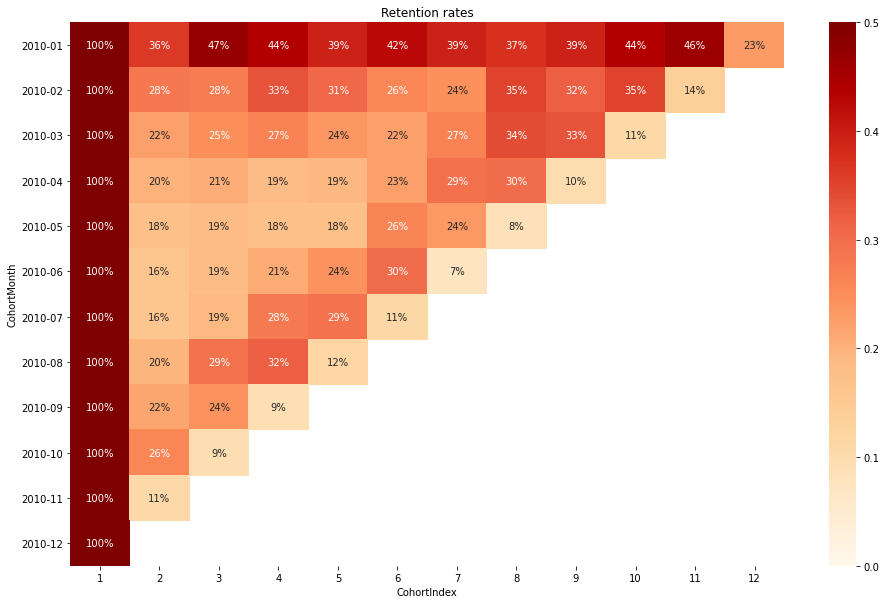

In [30]:
plt.figure(figsize = (16, 10))
plt.title('Average Standard Cost: Monthly Cohorts, fontsize =14')
#heatmap

plt.title('Retention rates')
sns.heatmap(data =retention,annot = True,fmt = '.0%',vmin = 0.0,vmax = 0.5,cmap = 'OrRd')
plt.ylabel('CohortMonth')
plt.xlabel('CohortIndex')
plt.yticks(rotation ='360')
plt.show()

### Summary

* The **retention rate Dataframe**
This represents Customer retained accross Cohorts. 
    * on the Y-axis we have the months in which the customers were acquired (the cohorts)
    * on the X-axis, we have the number of months after the first interaction (1,2,3, up to 12)
each square represents the percentage of returning users in a specific mon

* How can we read this plot to derive insight 

* Horizontally: Follow each cohort’s behavior across time(Month)
* Vertically: to compare values between cohorts:
* Diagonally: looking at calendar months (useful to spot issues in specific periods)
    
Lets take the the **30% of index 8 in the the 2010-04** date range. It means that **30%** of the users that **signed up** in **2010-04** are still **active** after **8months.** 
    



In [31]:
purchases2['Value'] = purchases2['Quantity']*purchases2['Price']
purchases2

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex,Value
45228,493410,TEST001,This is a test product.,5,2010-01-04 09:24:00,4.50,12346.0,United Kingdom,2010-01-01,2010-01-01,1,22.50
45230,493412,TEST001,This is a test product.,5,2010-01-04 09:53:00,4.50,12346.0,United Kingdom,2010-01-01,2010-01-01,1,22.50
45234,493414,21844,RETRO SPOT MUG,36,2010-01-04 10:28:00,2.55,14590.0,United Kingdom,2010-01-01,2010-01-01,1,91.80
45235,493414,21533,RETRO SPOT LARGE MILK JUG,12,2010-01-04 10:28:00,4.25,14590.0,United Kingdom,2010-01-01,2010-01-01,1,51.00
45236,493414,37508,NEW ENGLAND CERAMIC CAKE SERVER,2,2010-01-04 10:28:00,2.55,14590.0,United Kingdom,2010-01-01,2010-01-01,1,5.10
...,...,...,...,...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.0,United Kingdom,2010-12-01,2010-05-01,8,5.90
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom,2010-12-01,2010-05-01,8,3.75
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom,2010-12-01,2010-05-01,8,3.75
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.0,United Kingdom,2010-12-01,2010-05-01,8,7.50


In [32]:
# Instead of calculating the retention rate, we can also calculate the Lifetime value bought by each cohort
grouping2 = purchases2.groupby(['CohortMonth','CohortIndex'])
cohort_data2 = grouping2['Value'].sum()
cohort_data2 = cohort_data2.reset_index()
cohort_counts2 = cohort_data2.pivot(index='CohortMonth',
                                       columns = 'CohortIndex',
                                       values = 'Value')
cohort_counts2.round(1)

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,
2010-01-01,555802.7,265681.2,345479.2,280668.2,278274.5,280463.9,300593.8,304956.8,347502.0,397481.1,458596.0,161383.6
2010-02-01,238877.7,64524.8,87980.9,98260.1,82778.0,68638.9,73464.6,99868.9,96878.5,112467.5,31791.9,NaN
2010-03-01,286974.4,70514.3,70930.8,85117.3,64255.4,76105.1,95871.0,131243.1,152005.7,25432.2,NaN,NaN
2010-04-01,152818.6,23870.0,27464.0,38915.1,30028.4,39719.0,46882.2,51213.2,11661.9,NaN,NaN,NaN
2010-05-01,126497.9,17521.4,18630.0,14891.1,20111.8,37820.7,32172.6,5985.2,NaN,NaN,NaN,NaN
2010-06-01,143026.5,16588.8,23881.0,29899.1,44443.1,58863.3,12206.4,NaN,NaN,NaN,NaN,NaN
2010-07-01,82114.1,10612.5,16325.7,27553.3,30919.9,7851.0,NaN,NaN,NaN,NaN,NaN,NaN
2010-08-01,68285.0,14698.4,24624.4,26124.4,8535.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09-01,165018.0,29861.5,33696.8,9243.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
# Store the first column as cohort sizes
cohort_sizes2 = cohort_counts2.iloc[:,0]
# Divide all values in the cohort_counts table by cohort_sizes
value = cohort_counts2.divide(cohort_sizes2, axis = 0)
value.index =value.index.strftime('%Y-%m')
# Review the purchase table
value.round(3)*100

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,
2010-01,100.0,47.8,62.2,50.5,50.1,50.5,54.1,54.9,62.5,71.5,82.5,29.0
2010-02,100.0,27.0,36.8,41.1,34.7,28.7,30.8,41.8,40.6,47.1,13.3,NaN
2010-03,100.0,24.6,24.7,29.7,22.4,26.5,33.4,45.7,53.0,8.9,NaN,NaN
2010-04,100.0,15.6,18.0,25.5,19.6,26.0,30.7,33.5,7.6,NaN,NaN,NaN
2010-05,100.0,13.9,14.7,11.8,15.9,29.9,25.4,4.7,NaN,NaN,NaN,NaN
2010-06,100.0,11.6,16.7,20.9,31.1,41.2,8.5,NaN,NaN,NaN,NaN,NaN
2010-07,100.0,12.9,19.9,33.6,37.7,9.6,NaN,NaN,NaN,NaN,NaN,NaN
2010-08,100.0,21.5,36.1,38.3,12.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09,100.0,18.1,20.4,5.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


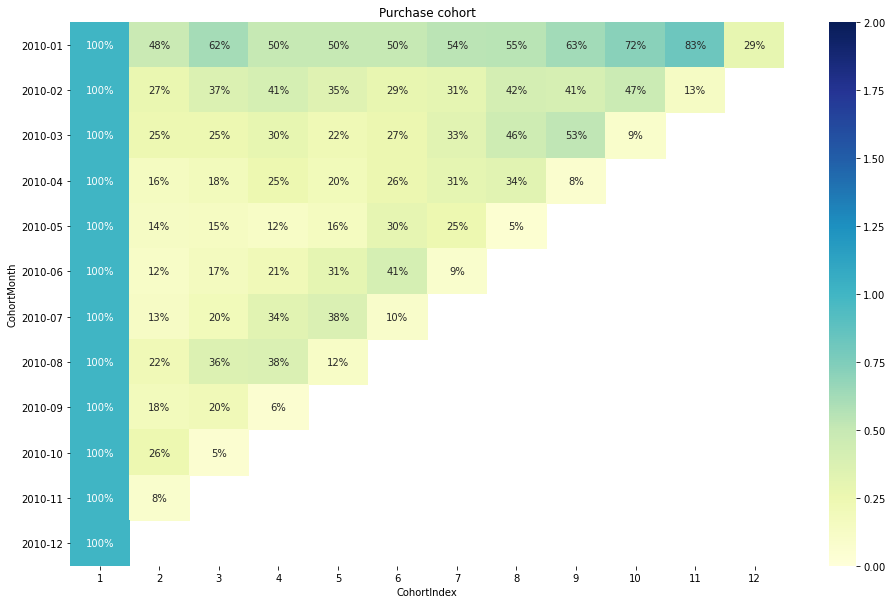

In [35]:
#Visualize the chart using Heat map 
plt.figure(figsize = (16, 10))
plt.title('Average Standard Purchase: Monthly Cohorts, fontsize =14')
#heatmap
plt.title('Purchase cohort')
sns.heatmap(data =value,annot = True,fmt = '.0%',vmin = 0.0,vmax = 2.0,cmap = 'YlGnBu')
plt.ylabel('CohortMonth')
plt.xlabel('CohortIndex')
plt.yticks(rotation ='360')
plt.show()

### Summary

* The **purchasing rate Dataframe**
This represents Customer purchases accross Cohorts. 
    * on the Y-axis we have the months in which the customers purchases were made (the cohorts)
    * on the X-axis, we have the number of months after the first interaction (1,2,3, up to 12)
each square represents the percentage of purchases made by returned users.

* How can we read this plot to derive insight 

* Horizontally: Follow each cohort’s behavior across time
    
Lets take the the **83% value of cohort 11 in 2010-01**. **This means that**:

After **11 months,** the users that **signed up** in **2010-01** still gave up to **83%** with respect to the first month value.


